Train the Unsupervised Model (Isolation Forest) 

Loading Data...
⚙️ Building Preprocessing Pipeline...
Pipeline Fitted and Data Transformed

Training Stage 1: Isolation Forest (Normality Model)...
Gatekeeper Trained!

Training Stage 2: Random Forest (Attack Classifier)...
Specialist Trained!

Testing the Full System on Test Set...

Final Classification Report:
              precision    recall  f1-score   support

         DoS       1.00      0.90      0.95     13778
      Normal       0.85      0.99      0.92     20203
       Probe       0.94      0.50      0.66      3497
         R2L       0.41      0.06      0.11       298
         U2R       0.05      0.06      0.05        16

    accuracy                           0.90     37792
   macro avg       0.65      0.50      0.54     37792
weighted avg       0.91      0.90      0.90     37792



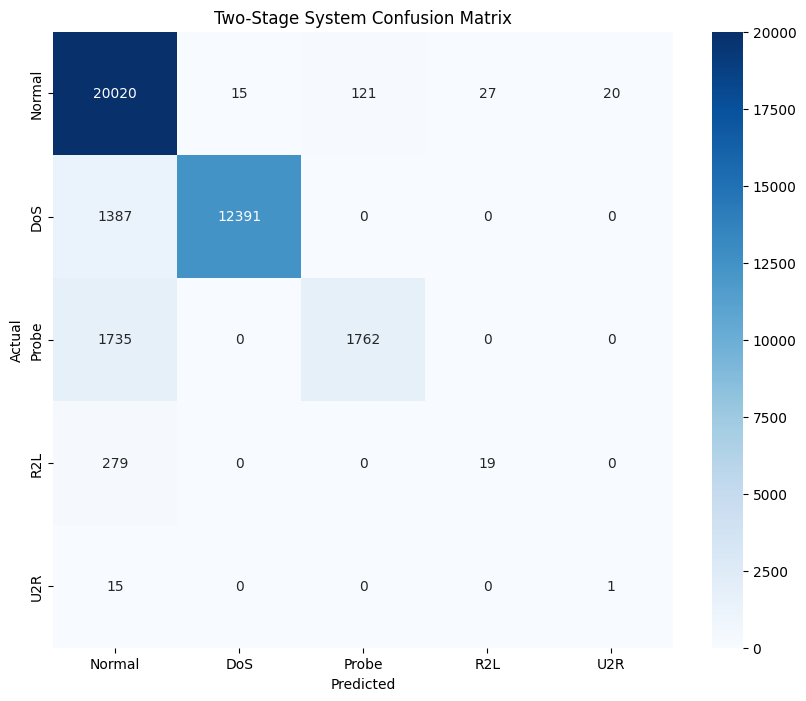

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. LOAD & PREPARE DATA
# ==========================================
print("Loading Data...")

# Load Raw Normal Data (for fitting the scaler/encoder correctly)
# We use the original train_set to ensure we catch all categories
df_train = pd.read_csv('../data/train_set.csv')
df_normal = df_train[df_train['label'] == 'normal']

# Load Balanced Attacks (for Stage 2)
df_attacks = pd.read_csv('../data/balanced_anomalies.csv')

# Load Test Set (Ground Truth for evaluation)
df_test = pd.read_csv('../data/test_set.csv')

# Define Features
categorical_cols = ['protocol_type', 'service', 'flag']
numerical_cols = [c for c in df_train.columns if c not in categorical_cols + ['label', 'difficulty_level', 'attack_group']]

# ==========================================
# 2. BUILD SHARED PREPROCESSING PIPELINE
# ==========================================
print("Building Preprocessing Pipeline...")

# We fit the preprocessor on the FULL training set (Normal + Attacks) 
# so it knows about all possible categories/ranges
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

# Fit on the full original training data
preprocessor.fit(df_train)

# Transform the datasets
X_normal_processed = preprocessor.transform(df_normal)
X_attacks_processed = preprocessor.transform(df_attacks)
X_test_processed = preprocessor.transform(df_test)

print("Pipeline Fitted and Data Transformed")

# ==========================================
# 3. TRAIN STAGE 1: ISOLATION FOREST (The Gatekeeper)
# ==========================================
print("\nTraining Stage 1: Isolation Forest (Normality Model)...")

# Since we are training ONLY on normal data, contamination should be very low 
# (we assume the training set is clean). 'auto' or 0.01 is good.
iso_forest = IsolationForest(contamination=0.01, random_state=42, n_jobs=-1)
iso_forest.fit(X_normal_processed)

print("Gatekeeper Trained!")

# ==========================================
# 4. TRAIN STAGE 2: RANDOM FOREST (The Specialist)
# ==========================================
print("\nTraining Stage 2: Random Forest (Attack Classifier)...")

# Prepare Targets for Stage 2
y_attacks = df_attacks['attack_group'] # DoS, Probe, R2L, etc.

# Train Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_classifier.fit(X_attacks_processed, y_attacks)

print("Specialist Trained!")


# ==========================================
# 6. EVALUATE THE FULL PIPELINE (Hierarchical)
# ==========================================
print("\nTesting the Full System on Test Set...")

# Step A: Gatekeeper Prediction
# Returns 1 for Normal (inlier), -1 for Anomaly (outlier)
gatekeeper_preds = iso_forest.predict(X_test_processed)

# Step B: Logic Flow
final_predictions = []

# We need to map the predicted anomaly indices to the processed array for Stage 2
anomaly_indices = [i for i, x in enumerate(gatekeeper_preds) if x == -1]
X_anomalies_detected = X_test_processed[anomaly_indices]

# Predict Attack Type for detected anomalies
if len(X_anomalies_detected) > 0:
    stage2_preds = rf_classifier.predict(X_anomalies_detected)
else:
    stage2_preds = []

# Reconstruct final labels
stage2_iter = iter(stage2_preds)
for pred in gatekeeper_preds:
    if pred == 1:
        final_predictions.append('Normal') # Isolation Forest said safe
    else:
        final_predictions.append(next(stage2_iter)) # Isolation Forest said sus -> RF classified it

# Step C: Compare with Ground Truth
# Map original labels to groups (Normal, DoS, Probe, etc.)
def map_label(label):
    if label == 'normal': return 'Normal'
    if label in ['neptune', 'smurf', 'pod', 'teardrop', 'land', 'back', 'apache2', 'udpstorm', 'processtable', 'worm']: return 'DoS'
    if label in ['satan', 'ipsweep', 'nmap', 'portsweep', 'mscan', 'saint']: return 'Probe'
    if label in ['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster', 'warezclient', 'spy', 'xlock', 'xsnoop', 'snmpguess', 'snmpgetattack', 'httptunnel', 'sendmail', 'named']: return 'R2L'
    if label in ['buffer_overflow', 'loadmodule', 'rootkit', 'perl', 'sqlattack', 'xterm', 'ps']: return 'U2R'
    return 'Other'

y_test_true_grouped = df_test['label'].apply(map_label)

# Report
print("\nFinal Classification Report:")
print(classification_report(y_test_true_grouped, final_predictions))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_true_grouped, final_predictions, labels=['Normal', 'DoS', 'Probe', 'R2L', 'U2R'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'DoS', 'Probe', 'R2L', 'U2R'], yticklabels=['Normal', 'DoS', 'Probe', 'R2L', 'U2R'])
plt.title('Two-Stage System Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Two issues Probe recall is 50% and R2L and U2R are over all low.
It shows that the model is maybe hesitated so attempt with different contaminations

Loading Data...
Building Preprocessing Pipeline...
Pipeline Fitted and Data Transformed

Training Stage 1: Isolation Forest (Normality Model)...
Gatekeeper Trained!

Training Stage 2: Random Forest (Attack Classifier)...
Specialist Trained!

Testing the Full System on Test Set...

Final Classification Report:
              precision    recall  f1-score   support

         DoS       1.00      0.93      0.96     13778
      Normal       0.92      0.95      0.93     20203
       Probe       0.78      0.87      0.82      3497
         R2L       0.24      0.07      0.11       298
         U2R       0.03      0.06      0.04        16

    accuracy                           0.93     37792
   macro avg       0.59      0.58      0.57     37792
weighted avg       0.93      0.93      0.93     37792



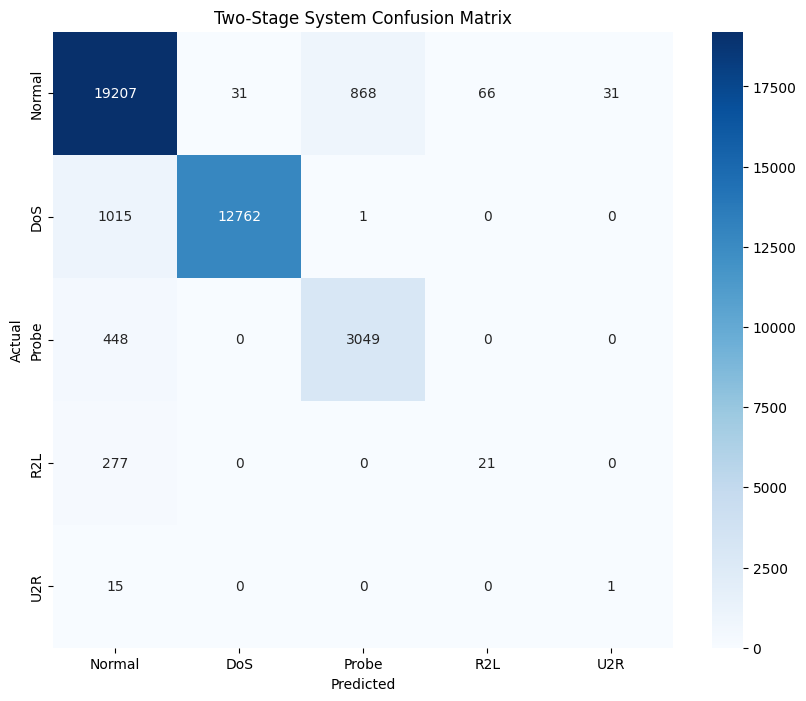

In [10]:
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. LOAD & PREPARE DATA
# ==========================================
print("Loading Data...")

# Load Raw Normal Data (for fitting the scaler/encoder correctly)
# We use the original train_set to ensure we catch all categories
df_train = pd.read_csv('../data/train_set.csv')
df_normal = df_train[df_train['label'] == 'normal']

# Load Balanced Attacks (for Stage 2)
df_attacks = pd.read_csv('../data/balanced_anomalies.csv')

# Load Test Set (Ground Truth for evaluation)
df_test = pd.read_csv('../data/test_set.csv')

# Define Features
categorical_cols = ['protocol_type', 'service', 'flag']
numerical_cols = [c for c in df_train.columns if c not in categorical_cols + ['label', 'difficulty_level', 'attack_group']]

# ==========================================
# 2. BUILD SHARED PREPROCESSING PIPELINE
# ==========================================
print("Building Preprocessing Pipeline...")

# We fit the preprocessor on the FULL training set (Normal + Attacks) 
# so it knows about all possible categories/ranges
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

# Fit on the full original training data
preprocessor.fit(df_train)

# Transform the datasets
X_normal_processed = preprocessor.transform(df_normal)
X_attacks_processed = preprocessor.transform(df_attacks)
X_test_processed = preprocessor.transform(df_test)

print("Pipeline Fitted and Data Transformed")

# ==========================================
# 3. TRAIN STAGE 1: ISOLATION FOREST (The Gatekeeper)
# ==========================================
print("\nTraining Stage 1: Isolation Forest (Normality Model)...")

# Since we are training ONLY on normal data, contamination should be very low 
# Test for 0.05.
iso_forest = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1)
iso_forest.fit(X_normal_processed)

print("Gatekeeper Trained!")

# ==========================================
# 4. TRAIN STAGE 2: RANDOM FOREST (The Specialist)
# ==========================================
print("\nTraining Stage 2: Random Forest (Attack Classifier)...")

# Prepare Targets for Stage 2
y_attacks = df_attacks['attack_group'] # DoS, Probe, R2L, etc.

# Train Classifier
# Change this:
# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# To this (Add class_weight):
rf_classifier = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1,
    class_weight='balanced_subsample'  # <--- THIS IS KEY
)
rf_classifier.fit(X_attacks_processed, y_attacks)

print("Specialist Trained!")


# ==========================================
# 6. EVALUATE THE FULL PIPELINE (Hierarchical)
# ==========================================
print("\nTesting the Full System on Test Set...")

# Step A: Gatekeeper Prediction
# Returns 1 for Normal (inlier), -1 for Anomaly (outlier)
gatekeeper_preds = iso_forest.predict(X_test_processed)

# Step B: Logic Flow
final_predictions = []

# We need to map the predicted anomaly indices to the processed array for Stage 2
anomaly_indices = [i for i, x in enumerate(gatekeeper_preds) if x == -1]
X_anomalies_detected = X_test_processed[anomaly_indices]

# Predict Attack Type for detected anomalies
if len(X_anomalies_detected) > 0:
    stage2_preds = rf_classifier.predict(X_anomalies_detected)
else:
    stage2_preds = []

# Reconstruct final labels
stage2_iter = iter(stage2_preds)
for pred in gatekeeper_preds:
    if pred == 1:
        final_predictions.append('Normal') # Isolation Forest said safe
    else:
        final_predictions.append(next(stage2_iter)) # Isolation Forest said sus -> RF classified it

# Step C: Compare with Ground Truth
# Map original labels to groups (Normal, DoS, Probe, etc.)
def map_label(label):
    if label == 'normal': return 'Normal'
    if label in ['neptune', 'smurf', 'pod', 'teardrop', 'land', 'back', 'apache2', 'udpstorm', 'processtable', 'worm']: return 'DoS'
    if label in ['satan', 'ipsweep', 'nmap', 'portsweep', 'mscan', 'saint']: return 'Probe'
    if label in ['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster', 'warezclient', 'spy', 'xlock', 'xsnoop', 'snmpguess', 'snmpgetattack', 'httptunnel', 'sendmail', 'named']: return 'R2L'
    if label in ['buffer_overflow', 'loadmodule', 'rootkit', 'perl', 'sqlattack', 'xterm', 'ps']: return 'U2R'
    return 'Other'

y_test_true_grouped = df_test['label'].apply(map_label)

# Report
print("\nFinal Classification Report:")
print(classification_report(y_test_true_grouped, final_predictions))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_true_grouped, final_predictions, labels=['Normal', 'DoS', 'Probe', 'R2L', 'U2R'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'DoS', 'Probe', 'R2L', 'U2R'], yticklabels=['Normal', 'DoS', 'Probe', 'R2L', 'U2R'])
plt.title('Two-Stage System Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In R2L and U2R, performance may be lower due to their rarity and subtlety in network traffic.
More representative training data could help improve results in these categories, but I do not have access to such data.

This an attempt to see why isolation model fail in these two

          duration      src_bytes     dst_bytes  num_failed_logins  \
group                                                                
Normal  174.484514   14025.549873   4483.189415           0.001273   
R2L     590.969871  291616.538020  85523.017217           0.057389   
U2R      75.972222     682.027778   5829.694444           0.000000   

        root_shell       hot  
group                         
Normal    0.002058  0.228659  
R2L       0.007174  8.751793  
U2R       0.444444  1.166667  

Root Shell counts:
group   root_shell
Normal  0             0.997942
        1             0.002058
R2L     0             0.992826
        1             0.007174
U2R     0             0.555556
        1             0.444444
Name: proportion, dtype: float64


C:\Users\HP\AppData\Local\Temp\ipykernel_21684\2044736537.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df['log_src_bytes'] = np.log1p(comparison_df['src_bytes'])


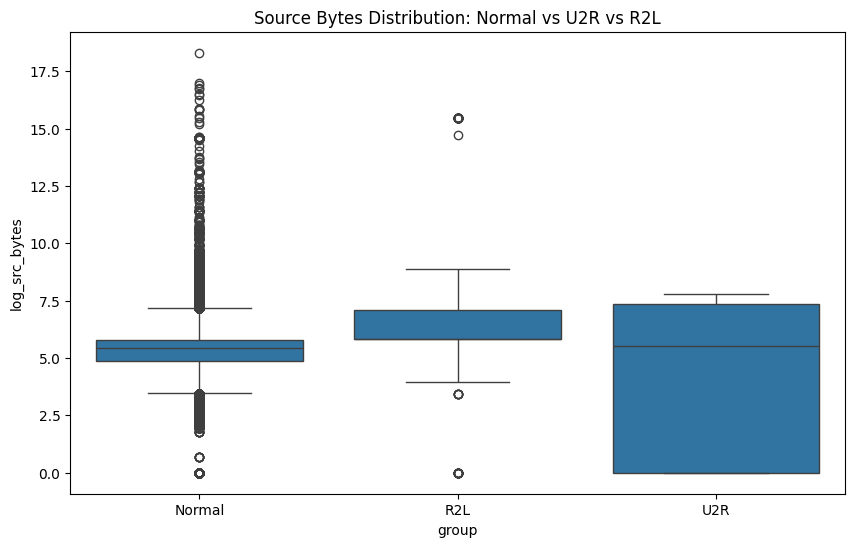

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the training data
df = pd.read_csv('../data/train_set.csv')

# Define groups
def get_group(label):
    if label == 'normal': return 'Normal'
    if label in ['buffer_overflow', 'loadmodule', 'rootkit', 'perl', 'sqlattack', 'xterm', 'ps']: return 'U2R'
    if label in ['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster', 'warezclient', 'spy', 'xlock', 'xsnoop', 'snmpguess', 'snmpgetattack', 'httptunnel', 'sendmail', 'named']: return 'R2L'
    return 'Other'

df['group'] = df['label'].apply(get_group)

# Filter for Normal, U2R, R2L
comparison_df = df[df['group'].isin(['Normal', 'U2R', 'R2L'])]

# Select features that should distinguish these attacks
features = ['duration', 'src_bytes', 'dst_bytes', 'num_failed_logins', 'root_shell', 'hot']

# Calculate mean/median to see differences
print(comparison_df.groupby('group')[features].mean())

# Check overlap in basic features (e.g. src_bytes)
# Since bytes vary largely, we look at log scale
import numpy as np
comparison_df['log_src_bytes'] = np.log1p(comparison_df['src_bytes'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='log_src_bytes', data=comparison_df)
plt.title('Source Bytes Distribution: Normal vs U2R vs R2L')
plt.savefig('u2r_r2l_overlap.png')

# Check 'root_shell' counts (this should be the smoking gun for U2R)
print("\nRoot Shell counts:")
print(comparison_df.groupby('group')['root_shell'].value_counts(normalize=True))

--- Feature Comparison (Median Values) ---
                 duration  src_bytes  dst_bytes  count  srv_count
attack_category                                                  
DoS                   0.0        0.0        0.0  173.0       11.0
Normal                0.0      233.0      379.0    4.0        5.0
Probe                 0.0        1.0        0.0    1.0        2.0
R2L                   0.0      334.0        0.0    1.0        1.0
U2R                  32.0      247.0     3335.0    1.0        1.0

--- Feature Comparison (Mean Values) ---
                    duration      src_bytes      dst_bytes       count  \
attack_category                                                          
DoS                 0.005475    1177.641046     169.107344  178.273197   
Normal            174.484514   14025.549873    4483.189415   22.402100   
Probe            1991.074029  524350.940679  209620.525800   77.372227   
R2L               590.969871  291616.538020   85523.017217    1.295552   
U2R      

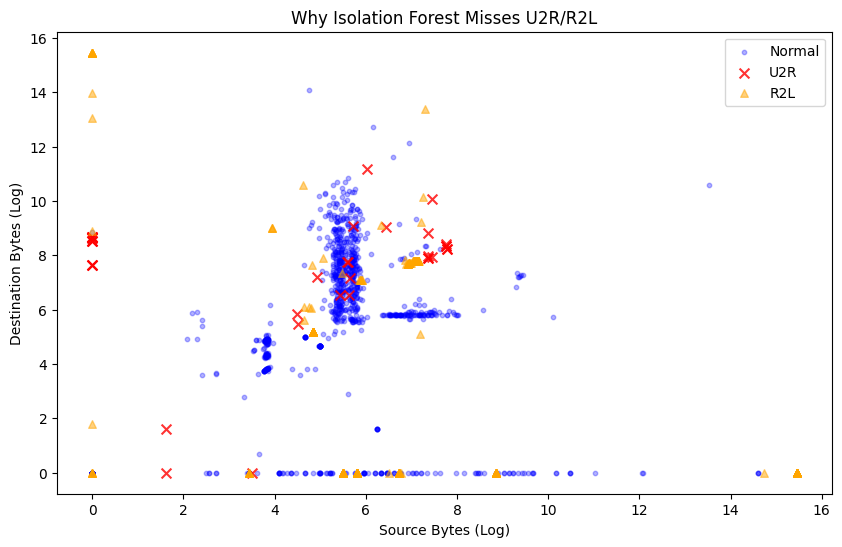

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
train_df = pd.read_csv('../data/train_set.csv')

# 2. Map Labels to Attack Categories
def get_attack_category(label):
    if label == 'normal': return 'Normal'
    if label in ['neptune', 'smurf', 'pod', 'teardrop', 'land', 'back', 'apache2', 'udpstorm', 'processtable', 'worm']: return 'DoS'
    if label in ['satan', 'ipsweep', 'nmap', 'portsweep', 'mscan', 'saint']: return 'Probe'
    if label in ['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster', 'warezclient', 'spy', 'xlock', 'xsnoop', 'snmpguess', 'snmpgetattack', 'httptunnel', 'sendmail', 'named']: return 'R2L'
    if label in ['buffer_overflow', 'loadmodule', 'rootkit', 'perl', 'sqlattack', 'xterm', 'ps']: return 'U2R'
    return 'Other'

train_df['attack_category'] = train_df['label'].apply(get_attack_category)

# 3. Analyze why U2R/R2L mimic Normal traffic
# Focus on features that Isolation Forest uses: duration, src_bytes, dst_bytes, count
features_to_compare = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count']

print("--- Feature Comparison (Median Values) ---")
median_stats = train_df.groupby('attack_category')[features_to_compare].median()
print(median_stats)

print("\n--- Feature Comparison (Mean Values) ---")
mean_stats = train_df.groupby('attack_category')[features_to_compare].mean()
print(mean_stats)

# 4. Check 'stealth' features for U2R specifically
print("\n--- Stealth Indicators for U2R ---")
u2r_stealth = train_df[train_df['attack_category'] == 'U2R'][['num_root', 'num_file_creations', 'root_shell']].mean()
normal_stealth = train_df[train_df['attack_category'] == 'Normal'][['num_root', 'num_file_creations', 'root_shell']].mean()

print("U2R Mean Values:")
print(u2r_stealth)
print("\nNormal Mean Values:")
print(normal_stealth)

# 5. Visualizing the overlap
# We'll plot src_bytes (log scale) vs duration for Normal vs U2R
plt.figure(figsize=(10, 6))
# Sample normal to avoid clutter
normal_sample = train_df[train_df['attack_category'] == 'Normal'].sample(n=1000, random_state=42)
u2r_data = train_df[train_df['attack_category'] == 'U2R']
r2l_data = train_df[train_df['attack_category'] == 'R2L']

plt.scatter(np.log1p(normal_sample['src_bytes']), np.log1p(normal_sample['dst_bytes']), 
            alpha=0.3, label='Normal', c='blue', s=10)
plt.scatter(np.log1p(u2r_data['src_bytes']), np.log1p(u2r_data['dst_bytes']), 
            alpha=0.8, label='U2R', c='red', marker='x', s=50)
plt.scatter(np.log1p(r2l_data['src_bytes']), np.log1p(r2l_data['dst_bytes']), 
            alpha=0.5, label='R2L', c='orange', marker='^', s=30)

plt.xlabel('Source Bytes (Log)')
plt.ylabel('Destination Bytes (Log)')
plt.title('Why Isolation Forest Misses U2R/R2L')
plt.legend()
plt.savefig('overlap_analysis.png')
print("\nOverlap plot saved.")

Its clear that U2R & R2L hide in the crowd

After more research on the U2R & R2L there are some significant flags that show them.
I will implement a bypass to detect the U2R &R2L using the 
significant flags :
    num_failed_logins > 2
    root_shell == 1
    num_file_creations > 1


<>:31: SyntaxWarning: invalid escape sequence '\E'
<>:31: SyntaxWarning: invalid escape sequence '\E'
C:\Users\HP\AppData\Local\Temp\ipykernel_21684\875870980.py:31: SyntaxWarning: invalid escape sequence '\E'
  print(f"\Error during preprocessing: {e}")


Loading Models...
Models Loaded
Reading data from ../data/test_set.csv...
Data Transformed
Stage 1: Running Gatekeeper...
Applying Bypass Rules for Stealth Attacks...
   -> Model found 16830 anomalies.
   -> Bypass Rules caught 33 EXTRA stealth attacks!
   -> Total Anomalies sending to Stage 2: 16863
Stage 2: Classifying Attacks...

Final Report (With Bypass Rules):
              precision    recall  f1-score   support

         DoS       0.99      0.93      0.96     13778
      Normal       0.92      0.95      0.93     20203
       Probe       0.79      0.87      0.83      3497
         R2L       0.24      0.07      0.11       298
         U2R       0.22      0.69      0.33        16

    accuracy                           0.93     37792
   macro avg       0.63      0.70      0.63     37792
weighted avg       0.93      0.93      0.93     37792



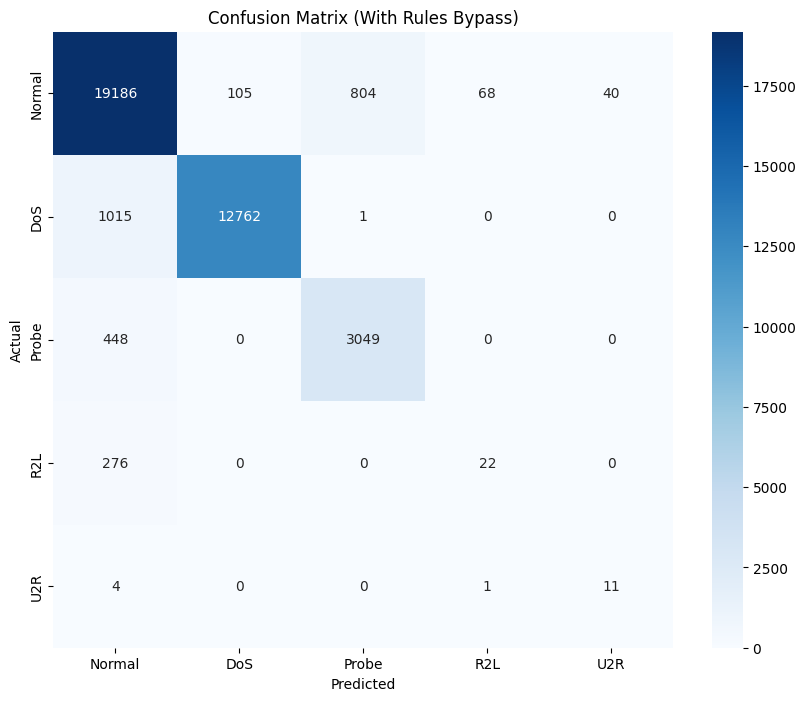

In [13]:
import pandas as pd
import joblib
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. SETUP & CONFIGURATION
# ==========================================
NEW_DATA_PATH = '../data/test_set.csv'  
MODEL_DIR = '../models'

print("Loading Models...")
preprocessor = joblib.load(f'{MODEL_DIR}/preprocessor.pkl')
iso_forest = joblib.load(f'{MODEL_DIR}/isolation_forest.pkl')
rf_classifier = joblib.load(f'{MODEL_DIR}/attack_classifier.pkl')
print("Models Loaded")

# ==========================================
# 2. LOAD & PREPROCESS
# ==========================================
print(f"Reading data from {NEW_DATA_PATH}...")
df_new = pd.read_csv(NEW_DATA_PATH)

# Transform data for the models (Scaling/Encoding)
try:
    X_processed = preprocessor.transform(df_new)
    print("Data Transformed")
except Exception as e:
    print(f"\Error during preprocessing: {e}")
    exit()

# ==========================================
# 3. STAGE 1: ISOLATION FOREST + BYPASS RULES
# ==========================================
print("Stage 1: Running Gatekeeper...")

# A. Standard Model Prediction (1 = Normal, -1 = Anomaly)
gatekeeper_preds = iso_forest.predict(X_processed)

# B. Apply "The Bypass" (Force Rules)
# We check the ORIGINAL dataframe for these flags
print("Applying Bypass Rules for Stealth Attacks...")
bypass_count = 0

for i in range(len(df_new)):
    # RULE 1: Root Shell (U2R indicator)
    # If someone gains root access, it's ALWAYS an anomaly, no matter what IsoForest says
    if df_new.iloc[i]['root_shell'] == 1:
        if gatekeeper_preds[i] == 1: # If model thought it was normal...
            gatekeeper_preds[i] = -1 # FORCE it to be an anomaly
            bypass_count += 1
            
    # RULE 2: Failed Logins (R2L indicator)
    # More than 2 failed logins is suspicious
    elif df_new.iloc[i]['num_failed_logins'] > 2:
        if gatekeeper_preds[i] == 1:
            gatekeeper_preds[i] = -1
            bypass_count += 1
            
    # RULE 3: File Creations (often used in R2L/U2R to drop viruses)
    # If file creations > 2 and NOT normal FTP traffic
    elif df_new.iloc[i]['num_file_creations'] > 2:
        if gatekeeper_preds[i] == 1:
            gatekeeper_preds[i] = -1
            bypass_count += 1

print(f"   -> Model found {np.sum(gatekeeper_preds == -1) - bypass_count} anomalies.")
print(f"   -> Bypass Rules caught {bypass_count} EXTRA stealth attacks!")
print(f"   -> Total Anomalies sending to Stage 2: {np.sum(gatekeeper_preds == -1)}")

# ==========================================
# 4. STAGE 2: THE SPECIALIST (Random Forest)
# ==========================================
print("Stage 2: Classifying Attacks...")

final_predictions = []
anomaly_indices = [i for i, x in enumerate(gatekeeper_preds) if x == -1]

# If we have anomalies, predict their specific type
if anomaly_indices:
    X_anomalies = X_processed[anomaly_indices]
    attack_preds = rf_classifier.predict(X_anomalies)
    attack_iter = iter(attack_preds)

# Construct final list
for status in gatekeeper_preds:
    if status == 1:
        final_predictions.append('Normal')
    else:
        final_predictions.append(next(attack_iter))

# ==========================================
# 5. EVALUATE PERFORMANCE
# ==========================================
# Map True Labels for Comparison
def get_true_group(label):
    if label == 'normal': return 'Normal'
    if label in ['neptune', 'smurf', 'pod', 'teardrop', 'land', 'back', 'apache2', 'udpstorm', 'processtable', 'worm']: return 'DoS'
    if label in ['satan', 'ipsweep', 'nmap', 'portsweep', 'mscan', 'saint']: return 'Probe'
    if label in ['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster', 'warezclient', 'spy', 'xlock', 'xsnoop', 'snmpguess', 'snmpgetattack', 'httptunnel', 'sendmail', 'named']: return 'R2L'
    if label in ['buffer_overflow', 'loadmodule', 'rootkit', 'perl', 'sqlattack', 'xterm', 'ps']: return 'U2R'
    return 'Other'

y_true = df_new['label'].apply(get_true_group)

print("\nFinal Report (With Bypass Rules):")
print(classification_report(y_true, final_predictions))

# Confusion Matrix
plt.figure(figsize=(10, 8))
labels = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']
cm = confusion_matrix(y_true, final_predictions, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (With Rules Bypass)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

After modification U2R showed a huge increase in recall.

Okay now we do it the clean way

Loading Models...
Loading Test Data...
Running Prediction Pipeline...

Final Classification Report:
              precision    recall  f1-score   support

         DoS       0.99      0.93      0.96     13778
      Normal       0.92      0.95      0.93     20203
       Probe       0.79      0.87      0.83      3497
         R2L       0.24      0.07      0.11       298
         U2R       0.22      0.69      0.33        16

    accuracy                           0.93     37792
   macro avg       0.63      0.70      0.63     37792
weighted avg       0.93      0.93      0.93     37792



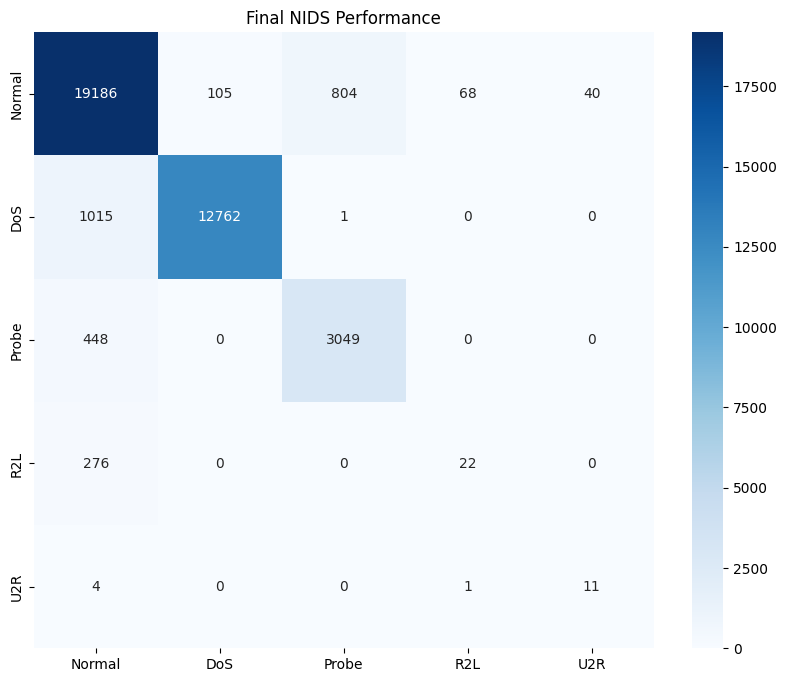

In [15]:
import pandas as pd
import numpy as np
import joblib
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. DEFINE THE WRAPPER CLASS
# ==========================================
class HierarchicalNIDS(BaseEstimator, ClassifierMixin):
    """
    A unified wrapper for the 2-Stage NIDS with Rule-Based Bypass.
    Input: Raw DataFrame.
    Output: Final Predictions (Normal, DoS, Probe, U2R, R2L).
    """
    def __init__(self, preprocessor, gatekeeper, specialist):
        self.preprocessor = preprocessor   # The ColumnTransformer
        self.gatekeeper = gatekeeper       # The Isolation Forest
        self.specialist = specialist       # The Random Forest

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        """
        Runs the full pipeline:
        1. Preprocess Data -> 2. Gatekeeper -> 3. Bypass Rules -> 4. Specialist
        """
        # Ensure X is a DataFrame (needed for logic rules)
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input X must be a pandas DataFrame with feature names.")

        # --- STEP 1: PREPROCESS ---
        X_processed = self.preprocessor.transform(X)

        # --- STEP 2: GATEKEEPER (Anomaly Detection) ---
        # 1 = Normal, -1 = Anomaly
        gatekeeper_preds = self.gatekeeper.predict(X_processed)

        # --- STEP 3: BYPASS RULES (Increase Recall) ---
        # Modify the gatekeeper_preds array directly based on rules using Boolean Masks
        
        # Rule 1: Root Shell = Always Anomaly (U2R)
        if 'root_shell' in X.columns:
            # Mask: Has root shell AND was predicted Normal
            mask_u2r = (X['root_shell'] == 1) & (gatekeeper_preds == 1)
            gatekeeper_preds[mask_u2r] = -1

        # Rule 2: High Failed Logins = Always Anomaly (R2L)
        if 'num_failed_logins' in X.columns:
            mask_r2l = (X['num_failed_logins'] > 2) & (gatekeeper_preds == 1)
            gatekeeper_preds[mask_r2l] = -1

        # Rule 3: High File Creations = Always Anomaly
        if 'num_file_creations' in X.columns:
            mask_files = (X['num_file_creations'] > 2) & (gatekeeper_preds == 1)
            gatekeeper_preds[mask_files] = -1

        # --- STEP 4: SPECIALIST (Classification) ---
        # Initialize final array with "Normal"
        final_preds = np.array(["Normal"] * len(X), dtype=object)

        # Find indices that are NOW flagged as anomalies
        anomaly_indices = np.where(gatekeeper_preds == -1)[0]

        if len(anomaly_indices) > 0:
            # Predict only for the anomalies
            X_anomalies = X_processed[anomaly_indices]
            specialist_preds = self.specialist.predict(X_anomalies)
            
            # Place predictions into the final array
            final_preds[anomaly_indices] = specialist_preds

        return final_preds

# ==========================================
# 2. RUN THE PIPELINE
# ==========================================
print("Loading Models...")
MODEL_DIR = '../models' # Make sure this path is correct for your notebook
preprocessor = joblib.load(f'{MODEL_DIR}/preprocessor.pkl')
iso_forest = joblib.load(f'{MODEL_DIR}/isolation_forest.pkl')
rf_classifier = joblib.load(f'{MODEL_DIR}/attack_classifier.pkl')

# Instantiate the Super Model
nids_system = HierarchicalNIDS(preprocessor, iso_forest, rf_classifier)

print("Loading Test Data...")
df_test = pd.read_csv('../data/test_set.csv')

print("Running Prediction Pipeline...")
final_predictions = nids_system.predict(df_test)

# ==========================================
# 3. EVALUATE
# ==========================================
def get_true_group(label):
    if label == 'normal': return 'Normal'
    if label in ['neptune', 'smurf', 'pod', 'teardrop', 'land', 'back', 'apache2', 'udpstorm', 'processtable', 'worm']: return 'DoS'
    if label in ['satan', 'ipsweep', 'nmap', 'portsweep', 'mscan', 'saint']: return 'Probe'
    if label in ['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster', 'warezclient', 'spy', 'xlock', 'xsnoop', 'snmpguess', 'snmpgetattack', 'httptunnel', 'sendmail', 'named']: return 'R2L'
    if label in ['buffer_overflow', 'loadmodule', 'rootkit', 'perl', 'sqlattack', 'xterm', 'ps']: return 'U2R'
    return 'Other'

y_true = df_test['label'].apply(get_true_group)

print("\nFinal Classification Report:")
print(classification_report(y_true, final_predictions))

# Optional: Plot Matrix
plt.figure(figsize=(10, 8))
labels = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']
cm = confusion_matrix(y_true, final_predictions, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Final NIDS Performance')
plt.show()